In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib import rc
from astropy.cosmology import Planck15
import astropy.units as u

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [2]:
def dVdz(z):
    return 4.*np.pi*Planck15.differential_comoving_volume(z).to(u.Gpc**3/u.sr).value

In [3]:
# Load injection set
mockDetections = h5py.File('/home/reed.essick/rates+pop/o1+o2+o3-sensitivity-estimates/LIGO-T2100377-v2/o1+o2+o3_bnspop_real+semianalytic-LIGO-T2100377-v2.hdf5','r')

# Get total observation time and number of trials
year = 365.25*24*3600
Tobs = mockDetections.attrs['analysis_time_s']/year
nTrials = mockDetections.attrs['total_generated']

# Read out ifars and SNRs
ifar_1 = mockDetections['injections']['ifar_gstlal'][()]
ifar_2 = mockDetections['injections']['ifar_pycbc_bbh'][()]
ifar_3 = mockDetections['injections']['ifar_pycbc_hyperbank'][()]
snr = mockDetections['injections']['optimal_snr_net'][()]

# Get "detected" events, based on FAR in O3 and SNR in O1/O2
ifar_threshold = 1.
snr_threshold = 10.
detected_O3 = np.where((ifar_1>ifar_threshold) | (ifar_2>ifar_threshold) | (ifar_3>ifar_threshold))[0]
detected_O1O2 = np.where((mockDetections['injections']['name'][()]!=b'o3') & (snr>snr_threshold))[0]
detected_full = np.concatenate([detected_O1O2,detected_O3])

# Strip out event properties, compute dVdz
m1_det = np.array(mockDetections['injections']['mass1_source'][()])[detected_full]
m2_det = np.array(mockDetections['injections']['mass2_source'][()])[detected_full]
s1x_det = np.array(mockDetections['injections']['spin1x'][()])[detected_full]
s1y_det = np.array(mockDetections['injections']['spin1y'][()])[detected_full]
s1z_det = np.array(mockDetections['injections']['spin1z'][()])[detected_full]
s2x_det = np.array(mockDetections['injections']['spin2x'][()])[detected_full]
s2y_det = np.array(mockDetections['injections']['spin2y'][()])[detected_full]
s2z_det = np.array(mockDetections['injections']['spin2z'][()])[detected_full]
z_det = np.array(mockDetections['injections']['redshift'][()])[detected_full]
dVdz_det = dVdz(z_det)
a1_det = np.sqrt(s1x_det**2+s1y_det**2+s1z_det**2)
a2_det = np.sqrt(s2x_det**2+s2y_det**2+s2z_det**2)

# Also get full draw probabilities
p_draw = np.array(mockDetections['injections']['sampling_pdf'][()])[detected_full]

In [4]:
# Now we need to specify our target population properties

# First, redshift
# Aim for p(z) following star formation
target_kappa = 2.7

# Compute the necessary normalization factor
z_grid = np.linspace(0,0.5,1000)
dVdz_grid = dVdz(z_grid)
pz_norm = np.trapz(dVdz_grid*(1.+z_grid)**(target_kappa-1.),z_grid)

# Put redshift ingredients together
target_pz = dVdz_det*(1.+z_det)**(target_kappa-1)/pz_norm

# Masses
# Assume uniform mass distribution between 1-2.5 Msun
deltaM = 2.5-1.
m1m2_area = 0.5*deltaM**2
target_p_m1m2 = 1./m1m2_area

In [5]:
# Let's now consider two cases, one in which spins are allowed to be large and one in which they're small

# High spin case
a_max_high = 0.4

# New injection probabilities for component spins s1x, s1y, s1z
target_pspin1_high = (1./(4.*np.pi))/a_max_high/(s1x_det**2+s1y_det**2+s1z_det**2)
target_pspin2_high = (1./(4.*np.pi))/a_max_high/(s2x_det**2+s2y_det**2+s2z_det**2)

# Zero out any probabilities with spins above our threshold
target_pspin1_high[a1_det>a_max_high] = 0
target_pspin2_high[a2_det>a_max_high] = 0

# Same for low spins
a_max_low = 0.1
target_pspin1_low = (1./(4.*np.pi))/a_max_low/(s1x_det**2+s1y_det**2+s1z_det**2)
target_pspin2_low = (1./(4.*np.pi))/a_max_low/(s2x_det**2+s2y_det**2+s2z_det**2)
target_pspin1_low[a1_det>a_max_low] = 0
target_pspin2_low[a2_det>a_max_low] = 0

In [6]:
# Detection efficiencies
det_efficiency_high = (1./nTrials)*np.sum(target_pz*target_pspin1_high*target_pspin2_high*target_p_m1m2/p_draw)
det_efficiency_low = (1./nTrials)*np.sum(target_pz*target_pspin1_low*target_pspin2_low*target_p_m1m2/p_draw)

In [7]:
# Grid of log rates
log_R0s = np.linspace(0,4,100)

# Loop across grid, compute p(logR) assume high spins
p_log_R0_high = np.zeros(log_R0s.size)
for i,log_R0 in enumerate(log_R0s):
    
    R0 = 10.**log_R0
    
    # Expected number of detections.
    # Note that pz_norm is the total spacetime volume out to zMax = 2.3
    Nexp = R0*pz_norm*Tobs*det_efficiency_high
    
    # Rate likelihood.
    # The extra det_efficiency_high**2 factor comes from the evidence weighting
    # in the "single event" part of our population likelihood
    p_log_R0_high[i] = Nexp**2.*np.exp(-Nexp)/det_efficiency_high**2

# Same for low spins
p_log_R0_low = np.zeros(log_R0s.size)
for i,log_R0 in enumerate(log_R0s):
    
    R0 = 10.**log_R0
    Nexp = R0*pz_norm*Tobs*det_efficiency_low
    p_log_R0_low[i] = Nexp**2.*np.exp(-Nexp)/det_efficiency_low**2

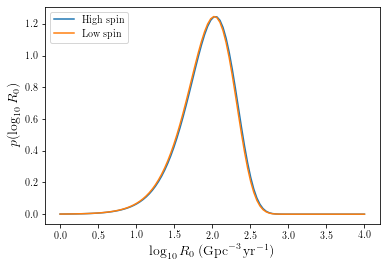

114.97569953977369


In [8]:
# Normalize and plot
p_log_R0_high /= np.trapz(p_log_R0_high,log_R0s)
p_log_R0_low /= np.trapz(p_log_R0_low,log_R0s)

fig,ax = plt.subplots()
ax.plot(log_R0s,p_log_R0_high,label='High spin')
ax.plot(log_R0s,p_log_R0_low,label='Low spin')
ax.set_xlabel(r'$\log_{10}R_0\,(\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1})$',fontsize=14)
ax.set_ylabel(r'$p(\log_{10}R_0)$',fontsize=14)
plt.legend(loc='upper left')
plt.show()

print(10.**log_R0s[np.argmax(p_log_R0_high)])